In [3]:
import scipy
def GP(X1, y1, X2, kernel_func):
    """
    Calculate the posterior mean and covariance matrix for y2
    based on the corresponding input X2, the observations (y1, X1), 
    and the prior kernel function.
    """
    # Kernel of the observations
    Σ11 = kernel_func(X1, X1)
    # Kernel of observations vs to-predict
    Σ12 = kernel_func(X1, X2)
    print(np.linalg.cond(Σ11))
    print(np.linalg.cond(Σ12))
    # Solve
    solved = scipy.linalg.solve(Σ11, Σ12, assume_a='pos').T
    # Compute posterior mean
    μ2 = solved @ y1
    # Compute the posterior covariance
    Σ22 = kernel_func(X2, X2)
    Σ2 = Σ22 - (solved @ Σ12)
    return μ2, Σ2  # mean, covariance

def exponentiated_quadratic(xa, xb):
    """Exponentiated quadratic  with σ=1"""
    # L2 distance (Squared Euclidian)
    sq_norm = -0.5 * scipy.spatial.distance.cdist(xa, xb, 'sqeuclidean')
    return np.exp(sq_norm)

(8, 1)
107779.59579910786
1568.102901363987


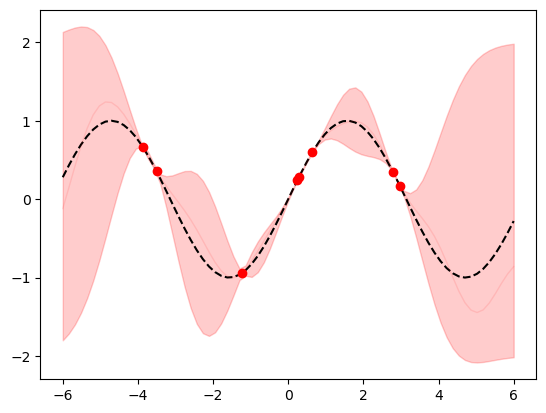

In [7]:
# Compute the posterior mean and covariance

# Define the true function that we want to regress on
f_sin = lambda x: (np.sin(x)).flatten()

n1 = 8  # Number of points to condition on (training points)
n2 = 75  # Number of points in posterior (test points)
ny = 5  # Number of functions that will be sampled from the posterior
domain = (-6, 6)

# Sample observations (X1, y1) on the function
X1 = (np.random.uniform(domain[0]+2, domain[1]-2, size=(n1))).reshape(-1,1)
print(X1.shape)      
y1 = f_sin(X1)
# Predict points at uniform spacing to capture function
X2 = (np.linspace(domain[0], domain[1], n2)).reshape(-1,1)
# Compute posterior mean and covariance
μ2, Σ2 = GP(X1, y1, X2, exponentiated_quadratic)
# Compute the standard deviation at the test points to be plotted
σ2 = np.sqrt(np.diag(Σ2))

# Draw some samples of the posterior
y2 = np.random.multivariate_normal(mean=μ2, cov=Σ2)

plt.plot(X2, f_sin(X2), "k--", label="True (unknown)")
plt.plot(X1, y1, "ro", label="Training")
plt.plot(X2, y2.T, "r", linewidth=1, alpha=0.1)
plt.fill_between(X2.flat, μ2-2*σ2, μ2+2*σ2, color="r", alpha=0.2)
plt.show()

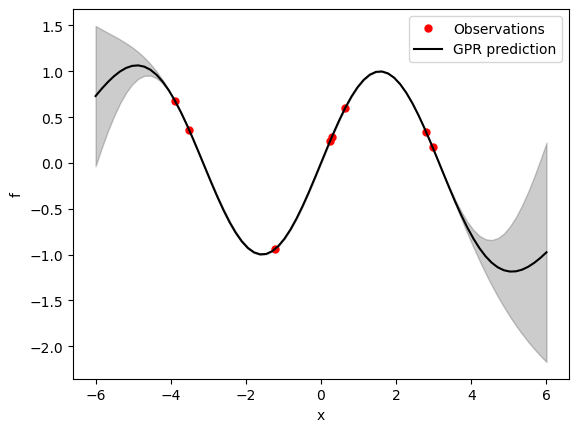

In [8]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

# the squared exponential kernel is RBF kernel
kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))

gpr = GaussianProcessRegressor(kernel=kernel)
# fit the model to the residuals
gpr.fit(X1.reshape(-1, 1), y1.reshape(-1, 1))

y2, sigma = gpr.predict(X2.reshape(-1,1), return_std=True)

plt.figure()
plt.plot(X1, y1, 'r.', markersize=10, label='Observations')
plt.plot(X2, y2, '-', color='black', label='GPR prediction')
plt.fill_between(X2.ravel(), y2 - 1.96 * sigma, y2 + 1.96 * sigma, alpha=0.2, color='k')
plt.xlabel('x')
plt.ylabel('f')
plt.legend()
plt.show()

In [21]:
def fit(x1, x2, f, kernel):

    from scipy.linalg import cho_solve, solve_triangular

    kernel = kernel
    K_11 = kernel.compute(x1)
    K_12 = kernel.compute(x1, x2)
    K_22 = kernel.compute(x2)

    #K_11[np.diag_indices_from(K_11)] += 1e-10 # adding jitter
    cond11 = np.linalg.cond(K_11)
    cond12 = np.linalg.cond(K_12)
    cond22 = np.linalg.cond(K_22)
    print(f"Condition number of K_11: {cond11}")
    print(f"Condition number of K_12: {cond12}")
    print(f"Condition number of K_22: {cond22}")

    L = cholesky(K_11)
    
    alpha = cho_solve((L,True), f) # cho_solve does A\f (where A = LL.T) as opposed to using solve_triangular to find (L\f) and then (L.T \ (L\f))
 
    v = solve_triangular(L, K_12, lower=True)
    mean_star = K_12.T @ alpha
    
    vTv = v.T@v
    cov_star = K_22 - vTv
    return mean_star, cov_star

(8,)
Condition number of K_11: 333.1666440016347
Condition number of K_12: 72.86926341627849
Condition number of K_22: 1.0195311024962039e+18
(8,)
(8, 8)


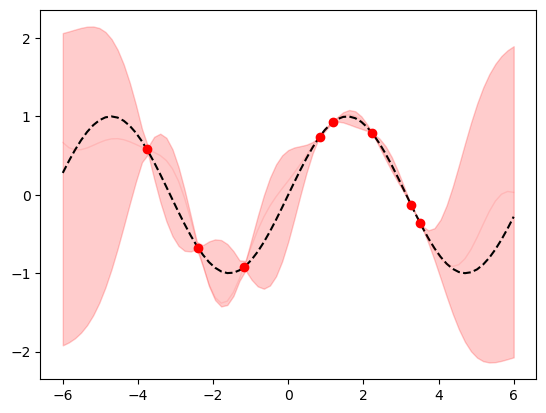

In [32]:
# Compute the posterior mean and covariance

# Define the true function that we want to regress on
f_sin = lambda x: (np.sin(x)).flatten()

n1 = 8  # Number of points to condition on (training points)
n2 = 75  # Number of points in posterior (test points)
ny = 5  # Number of functions that will be sampled from the posterior
domain = (-6, 6)

# Sample observations (X1, y1) on the function
X1 = np.random.uniform(domain[0]+2, domain[1]-2, size=n1)
print(X1.shape)      
y1 = f_sin(X1)
# Predict points at uniform spacing to capture function
X2 = np.linspace(domain[0], domain[1], n2)
# Compute posterior mean and covariance
μ2, Σ2 = fit(X1, X2, y1, some_kernel)
# Compute the standard deviation at the test points to be plotted
σ2 = np.sqrt(np.diag(Σ2))

# Draw some samples of the posterior
y2 = np.random.multivariate_normal(mean=μ2, cov=Σ2)

plt.plot(X2, f_sin(X2), "k--", label="True (unknown)")
plt.plot(X1, y1, "ro", label="Training")
plt.plot(X2, y2.T, "r", linewidth=1, alpha=0.1)
plt.fill_between(X2.flat, μ2-2*σ2, μ2+2*σ2, color="r", alpha=0.2)
plt.show()

Text(0.5, 0, 'x')

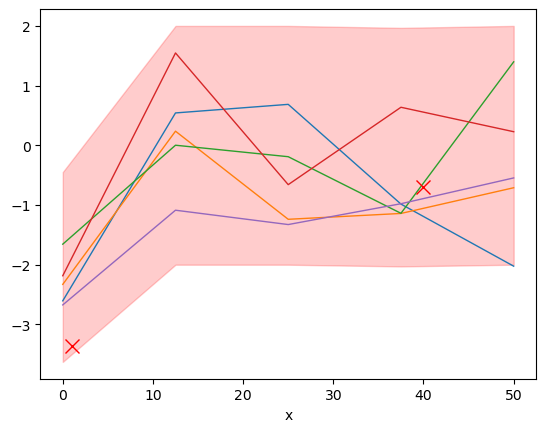

In [18]:
x2 = np.linspace(0, 50, 5).reshape(-1, 1)
x1 = np.array([1,40]).reshape(-1, 1)
cs2_1 = (np.array([0.033545,1/3]))
f1 = -np.log(1/cs2_1 - 1)
μ2, Σ2 = GP(x1, f1, x2, exponentiated_quadratic)

f2 = np.random.multivariate_normal(mean=μ2, cov=Σ2, size=ny)
σ2 = np.sqrt(np.diag(Σ2))

plt.plot(x2, f2.T, linewidth=1)
plt.fill_between(x2.flat, μ2-2*σ2, μ2+2*σ2, color="r", alpha=0.2)
plt.plot(x1, f1, 'rx', markersize=10)
plt.xlabel("x")

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sympy as sp
from scipy.integrate import cumulative_simpson as cumsimp
from scipy.linalg import cholesky, solve_triangular, solve



In [2]:
import dickandballs as db

In [9]:
some_kernel = db.Kernel('SE', sigma=1,l=1)

In [14]:
def fit(x1, x2, f, kernel):

    from scipy.linalg import cho_solve, solve_triangular

    kernel = kernel
    K_11 = kernel.compute(x1)
    K_12 = kernel.compute(x1, x2)
    K_22 = kernel.compute(x2)

    #K_11[np.diag_indices_from(K_11)] += 1e-10

    L = cholesky(K_11, lower=True)

    alpha = cho_solve((L,True), f) # cho_solve does A\f (where A = LL.T) as opposed to using solve_triangular to find (L\f) and then (L.T \ (L\f))
 
    v = solve_triangular(L, K_12, lower=True)

    mean_star = K_12.T @ alpha
    
    
    cov_star = K_22 - (v.T @ v)

    
    return mean_star, cov_star

kernel code works with unequal length arrays

In [11]:
x2 = np.linspace(0, 50, 5)
x1 = np.array([1,40])
cs2_1 = (np.array([0.033545,1/3]))
f1 = -np.log(1/cs2_1 - 1)

In [12]:
my_kernel = db.Kernel('SE', sigma=1, l=1)

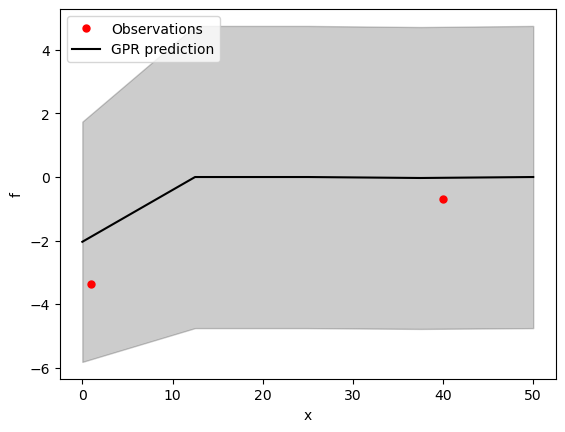

In [70]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

# the squared exponential kernel is RBF kernel
kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))

gpr = GaussianProcessRegressor(kernel=kernel)
# fit the model to the residuals
gpr.fit(x1.reshape(-1, 1), f1.reshape(-1, 1))

f2, sigma = gpr.predict(x2.reshape(-1,1), return_std=True)

plt.figure()
plt.plot(x1, f1, 'r.', markersize=10, label='Observations')
plt.plot(x2, f2, '-', color='black', label='GPR prediction')
plt.fill_between(x2.ravel(), f2 - 1.96 * sigma, f2 + 1.96 * sigma, alpha=0.2, color='k')
plt.xlabel('x')
plt.ylabel('f')
plt.legend()
plt.show()

In [28]:
def fit(x1, x2, f, kernel):

    from scipy.linalg import cho_solve,cho_factor

    kernel = kernel
    K_11 = kernel.compute(x1)
    K_12 = kernel.compute(x1, x2)
    K_22 = kernel.compute(x2)

    #K_11[np.diag_indices_from(K_11)] += 1e-10 # adding jitter
    cond11 = np.linalg.cond(K_11)
    cond12 = np.linalg.cond(K_12)
    cond22 = np.linalg.cond(K_22)
    print(f"Condition number of K_11: {cond11}")
    print(f"Condition number of K_12: {cond12}")
    print(f"Condition number of K_22: {cond22}")

    L = cholesky(K_11, lower=True)
    print(f.shape)
    print(L.shape)
    alpha = cho_solve((L,True), f) # cho_solve does A\f (where A = LL.T) as opposed to using solve_triangular to find (L\f) and then (L.T \ (L\f))
 
    v = solve_triangular(L, K_12, lower=True)

    mean_star = K_12.T @ alpha
    
    vTv = v.T@v
    cov_star = K_22 - vTv
    return mean_star, cov_star

Condition number of K_11: 1.0
Condition number of K_12: 13.804574186067095
Condition number of K_22: 1.0
(2,)
(2, 2)


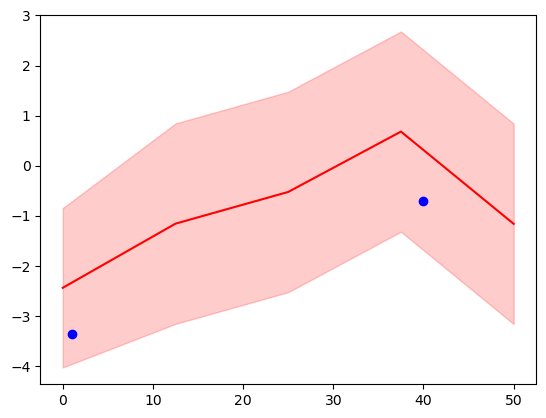

In [29]:
mean_star, cov_star = fit(x1,x2,f1,some_kernel)

y2 = np.random.multivariate_normal(mean_star, cov_star)
sig2 = np.sqrt(np.diag(cov_star))

plt.plot(x2, y2, 'r')
plt.fill_between(x2, y2 - 2*sig2, y2 + 2*sig2, color='r', alpha=0.2)
plt.scatter(x1, f1, color='b')
plt.show()